# 04. Pytorch custom datasets

Getting your own dataset to pytorch and solving your problem set

and look at pytorch domain libaries depending on what your working on.

## 0. Importing Pytorch and setup device agnostic code

In [1]:
# import pytorch
import torch
torch.__version__

'2.4.0+cu124'

In [2]:
# device agnostic code
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# check gpu if available
!nvidia-smi

Thu Sep 12 15:11:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8             N/A / ERR!  |      42MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data

our dataset is a subset of food101 dataset, which is only 3 classes and only 10% of the images.



In [4]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / 'pizza_steak_sushi'

# if the image folder doesn't exist, download and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory sudah ada, skipping download')
else:
    print(f'{image_path} tidak ada, mulai download')
    image_path.mkdir(parents=True, exist_ok=True)
    
# download the dataset from mrdbourke github
with open(data_path / 'pizza_steak_sushi.zip', mode="wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading dataset')
    f.write(requests.content)
    
# unzip dataset
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping dataset')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory sudah ada, skipping download
Unzipping dataset


## 2. Data preparation and data exploration

In [5]:
import os 
from helper_functions import walk_through_dir

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [7]:
# setup training and testing path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

### 2.1 Visualizing random images

tulis code untuk:
1. get all image path
2. pick a random image using python random
3. get image class name using `pathlib.Path.parent.stem`
4. open the image using python PIL(pillow)
5. show the image and print metadata

Random Image Path: data\pizza_steak_sushi\test\pizza\309892.jpg
Image Class: pizza
Image Height: 333
Image Width: 512


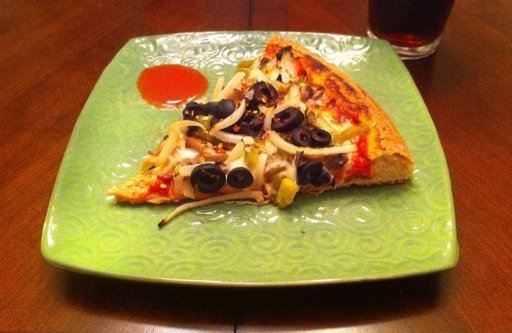

In [8]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get the image class from pathname
image_class =  random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random Image Path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

In [9]:
import matplotlib.pyplot as plt

In [10]:
# # try to visualize image with matplotlib
# import random
# from PIL import Image

# # set seed
# # random.seed(42)

# # 1. get all image path
# image_path_list = list(image_path.glob("*/*/*.jpg"))

# # 2. Create a 3x3 grid
# fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# # Loop to fill the grid with images
# for i in range(3):
#     for j in range(3):
#         # Pick a random image path
#         random_image_path = random.choice(image_path_list)
        
#         # Get the image class from the pathname
#         image_class = random_image_path.parent.stem
        
#         # Open image using matplotlib
#         img = plt.imread(random_image_path)
        
#         # Display the image in the corresponding subplot
#         axs[i, j].imshow(img)
#         axs[i, j].axis('off')  # Hide axes
        
#         # Set the label as the title of the subplot
#         axs[i, j].set_title(image_class)

# # Adjust layout
# plt.tight_layout()
# plt.show()

(-0.5, 511.5, 332.5, -0.5)

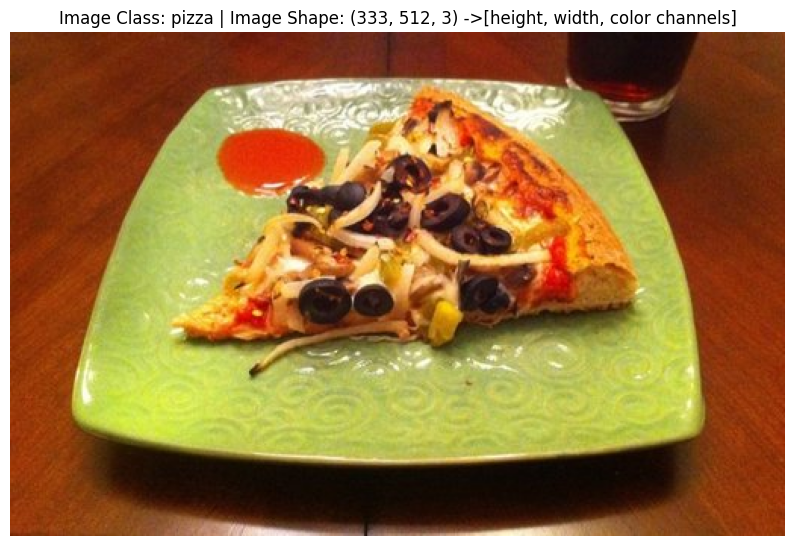

In [11]:
# daniel version
import numpy as np
import matplotlib.pyplot as plt

# turn the image into array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image Class: {image_class} | Image Shape: {img_as_array.shape} ->[height, width, color channels]')
plt.axis(False)

## 3. Turning image into pytorch

getting the image into tensor format.

before we can use our image data with pytorch:
1. turn your target data into tensors
2. turn it into a `torch.utils.data.Dataset` and into a `torch.utils.data.DataLoader`.


In [12]:
import torch
import torchvision
import torch.utils.data.dataloader as DataLoader
import torchvision.datasets as datasets
import torchvision.transforms.v2 as transforms

torchvision.__version__

'0.19.0+cu124'

### 3.1 Transforming data with torchvision transforms

In [13]:
# write a transform for image
data_transform = transforms.Compose([
    # resize image to 64x64
    transforms.Resize(size=(64, 64)),
    # flip the images horizontal randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # flip the images vertical randomly
    transforms.RandomVerticalFlip(p=0.5),
    # rotates the image randomly
    transforms.RandomRotation(degrees=30),
    # turn the image into torch.tensor
    transforms.ToImage(),
    # transforms.ToTensor() # deprecated
])

In [14]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

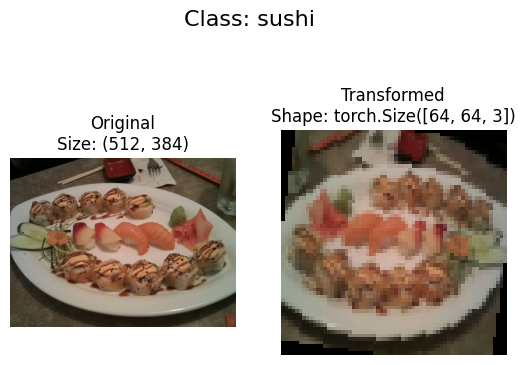

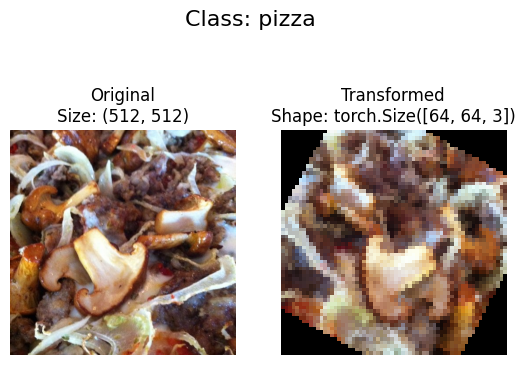

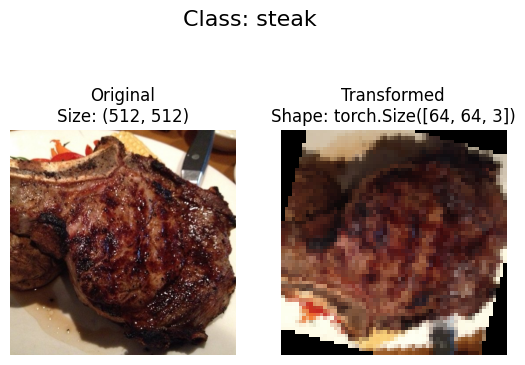

In [15]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `Image Folder`

load image classification data using `torchvision.datasets.ImageFolder`

In [16]:
# use ImageFolder to create datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  RandomVerticalFlip(p=0.5)
                  RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                  ToImage()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  RandomVerticalFlip(p=0.5)
                  RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                  ToImage()
            ))

In [ ]:
# get class names a list
class_names = train_data.classes
class_names

In [ ]:
# get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

In [ ]:
# check the length of datasets
len(train_data), len(test_data)

In [24]:
# index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]

Image([[[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]],

       [[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]],

       [[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8, )

In [ ]:
class_names[label]